In [30]:
import importlib
import loadData as ld
importlib.reload(ld)
import numpy as np
from keras.preprocessing.sequence import pad_sequences
import collections
import sklearn.decomposition as sk
import metrics
importlib.reload(metrics)

#To display word cloud 
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS, WordCloud



In [3]:
#Commande pour lancer sur Floyd  sudo floyd run --env keras --mode jupyter --cpu --data atarax/datasets/cnn_storiestgz/1:/data

#directory = "data/CNN"
#stories = ld.load_stories(directory)[:10000]

#Pour le l'entrainement sur le cloud
tarDirectory = "../data/sport.tar.gz"
stories = ld.load_stories_tgz(tarDirectory)
len(stories)

13420

In [4]:
stories[0]

{'highlights': ['There will be two games played in Ohio on Tuesday, tipping off the NCAA tournament',
  'The two leaders will conduct a joint interview at halftime of the first game',
  'Obama also launched an NCAA bracket challenge on his campaign website'],
 'story': '(CNN) -- President Barack Obama, a well-known basketball fan, will treat British Prime Minister David Cameron to a little March Madness Tuesday as the two head to Ohio to catch an NCAA men\'s tournament basketball game.\n\nThere will be two games tipping off the tournament in Dayton, Ohio, a swing state. During halftime of the first game, Western Kentucky versus Mississippi Valley State, the two leaders will conduct a joint interview.\n\nThe leaders\' trip to the game comes as Obama launched his new tournament "bracket challenge" on his campaign website.\n\nObama is asking those who visit the website to predict who will win the college basketball championship and to compare their picks against his.\n\n"It\'s college bas

In [5]:
#Embedding pré-entrainé : conceptNet > Glove 
embeddings_index = {}
with open('../data/numberbatch-en.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

In [6]:
corpus = ""

for document in stories:
    corpus += "_start_ " + ld.del_specialChars(document['story'])
    corpus += "_start_ " + ld.del_specialChars(' '.join(document['highlights']))

corpus = corpus.lower()
words = corpus.split(' ')

allWords = words
words=list(set(words))


VOCAB_SIZE = len(set(words))

if(VOCAB_SIZE > 40000):
    VOCAB_SIZE = 40000
    words = list(np.array(collections.Counter(allWords).most_common(VOCAB_SIZE))[:, 0])
    
words.remove("_start_")
words.insert(0, "_start_")       

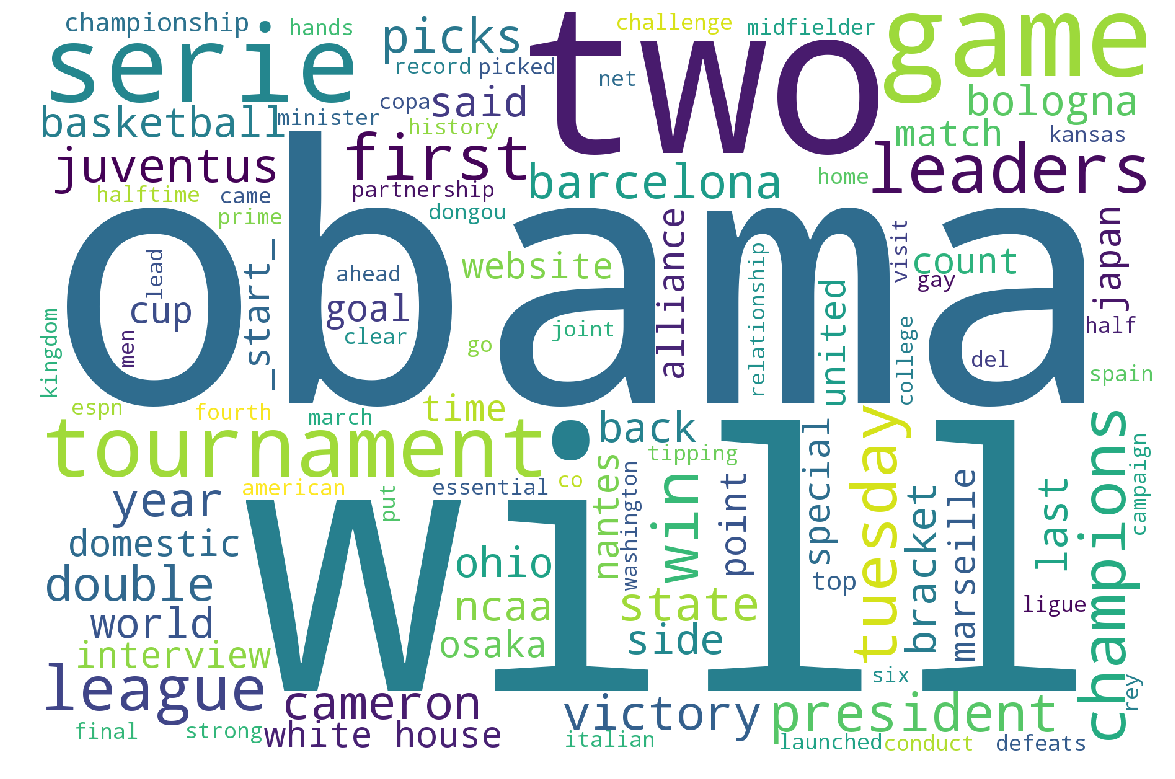

In [7]:
stopWords = set(STOPWORDS)

wc = WordCloud(background_color="white",
                                 max_words=100,
                                 stopwords= stopWords,
                                 width=1800, height=1200)

wc.generate(corpus[:6000])

plt.figure(figsize=(20,15))
plt.imshow(wc)
plt.axis("off")
plt.show()


In [8]:
#Recupération des embeddings des mots utilisés 

START_EMBEDDING_DIM = 300
EMBEDDING_DIM = 300

word_embedding_matrix = np.zeros((VOCAB_SIZE, START_EMBEDDING_DIM), 
                                 dtype=np.float32)

dicWords = collections.OrderedDict(zip(words, range(0, VOCAB_SIZE)))

for word, i in dicWords.items():
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        # If word not in CN, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, START_EMBEDDING_DIM))
        embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding
        
        
#pca = sk.PCA(n_components=EMBEDDING_DIM)

#word_embedding_matrix = pca.fit_transform(word_embedding_matrix)

np.shape(word_embedding_matrix)

(40000, 300)

In [9]:
#convert x_train and y_train words in index and make padding

x_train = []
y_train = []

print("toto : ", len(list(dicWords)))

for story in stories:    
    newStories = ld.split_articles(story['story'], story['highlights'], 4)

    for newStory in newStories:
        story_x, highlights_x = newStory
        x = ld.convertWordsToIndex(' '.join(ld.del_specialChars(story_x).split()[:100]), dicWords)
        y = ld.convertWordsToIndex(' '.join(ld.del_specialChars(highlights_x).split()[:40]), dicWords)

        x_train.append(np.array(x))
        y_train.append(np.array(y))
    
x_train = pad_sequences(x_train, padding='post')
y_train = pad_sequences(y_train, padding='post')

print("shape x_train : ", np.shape(x_train))
print("shape y_train : ", np.shape(y_train))

toto :  40000
shape x_train :  (64032, 100)
shape y_train :  (64032, 40)


In [10]:
print(ld.convertIndexToWords(x_train[58356], words))
print()
ld.convertIndexToWords(y_train[58356], words)

_start_ a dna test on the remains of chess legend bobby fischer has determined that he is not the father of a filipino girl the girl s lawyer told cnn on wednesday results of the test excluded the possibility that fischer who died in january 2008 was the father of young lawyer said this brings about the end of this paternity case he said in june iceland s supreme court ruled in favor of a request by young to fischer s remains in order to settle the question of paternity fischer s body was exhumed in _start_ _start_ _start_ _start_



'_start_ results show fischer is not the father of a filipino girl girl s lawyer says it ends the paternity case fischer s body was exhumed last month _start_ _start_ _start_ _start_ _start_ _start_ _start_ _start_ _start_ _start_ _start_ _start_'

In [11]:
#charger le modèle du cloud

from keras.models import load_model
base_model=load_model('../model/modelsport64000.h5')


In [ ]:
#Autre test 

#Ajout
doc_length = np.shape(x_train)[1]

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, Bidirectional, BatchNormalization
from keras import optimizers

#arbitrarly set latent dimension for embedding and hidden units
latent_dim = EMBEDDING_DIM

##### Define Model Architecture ######

########################
#### Encoder Model ####
encoder_inputs = Input(shape=(doc_length,), name='Encoder-Input')

# Word embeding for encoder (ex: Issue Body)
x = Embedding(VOCAB_SIZE, 
              EMBEDDING_DIM, 
              name='Body-Word-Embedding', 
              weights=[word_embedding_matrix],
              trainable=False,
              mask_zero=True)(encoder_inputs)

x = BatchNormalization(name='Encoder-Batchnorm-1')(x)

# We do not need the `encoder_output` just the hidden state.
_, state_h = GRU(latent_dim, return_state=True, name='Encoder-GRU')(x)


encoder_model = Model(inputs=encoder_inputs, 
                      outputs=state_h, 
                      name='Encoder-Model')

seq2seq_encoder_out = encoder_model(encoder_inputs)

########################
#### Decoder Model ####
decoder_inputs = Input(shape=(None,), name='Decoder-Input')  # for teacher forcing

# Word Embedding For Decoder (ex: Issue Titles)
dec_emb = Embedding(VOCAB_SIZE, 
                    EMBEDDING_DIM, 
                    name='Decoder-Word-Embedding',
                    weights=[word_embedding_matrix],
                    trainable=False,
                    mask_zero=True)(decoder_inputs)

dec_bn = BatchNormalization(name='Decoder-Batchnorm-1')(dec_emb)

# Set up the decoder, using `decoder_state_input` as initial state.
decoder_gru = GRU(latent_dim, 
                  return_state=True, 
                  return_sequences=True, 
                  name='Decoder-GRU')

decoder_gru_output, _ = decoder_gru(dec_bn, initial_state=seq2seq_encoder_out)
x = BatchNormalization(name='Decoder-Batchnorm-2')(decoder_gru_output)

# Dense layer for prediction
decoder_dense = Dense(VOCAB_SIZE, 
                      activation='softmax', 
                      name='Final-Output-Dense')

decoder_outputs = decoder_dense(x)


# Seq2Seq Model

#seq2seq_decoder_out = decoder_model([decoder_inputs, seq2seq_encoder_out])
seq2seq_Model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


seq2seq_Model.compile(optimizer=optimizers.Nadam(lr=0.001), 
loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [ ]:
seq2seq_Model.summary()


In [ ]:
# training
batch_size = 256
epochs = 5
history = seq2seq_Model.fit([x_train, y_train[:, :-1]], np.expand_dims(y_train[:, 1:], -1),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1, validation_split=0.12)

In [12]:
import utils as utl

importlib.reload(utl)

seq2seq_inf = utl.Seq2Seq_Inference(encoder_preprocessor=x_train,
                                 decoder_preprocessor=y_train,
                                 seq2seq_model=base_model,
                                 words2idx=dicWords,
                                 idx2words=words)

articleIdx=5001

test = list(x_train[articleIdx])

#print(stories[articleIdx])

print("Vrai résumé : ", ld.convertIndexToWords(test, words))
print()

seq2seq_inf.demo_model_predictions(np.array(test))




Vrai résumé :  _start_ london england the new italian serie a season kicks off with the first round of fixtures this weekend fanzone details what to expect from the forthcoming campaign: so what s new? the serie a managerial merry-go-round produced its usual raft of changes with over a third of clubs set to begin the season with a different coach from the previous campaign carlo ancelotti s departure to chelsea from ac milan is the most high-profile change with former rossoneri hero leonardo moving from his role as technical director at the club to take over as head coach walter zenga s



'southerners to real madrid in the champions league final understand won the european champions league title rivals real madrid and barcelona play their first game of the season their third'

In [33]:
#Evaluate the model

print(metrics.evaluate_supervised_model(seq2seq_inf, x_train, y_train, 3000, words))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
Done !
{'rouge-1': {'r': 0.12405254785409985, 'p': 0.0948511701868069, 'f': 0.10669144773444722}, 'rouge-2': {'r': 0.006190193518340643, 'p': 0.004746182961191165, 'f': 0.00534217117686174}, 'rouge-l': {'r': 0.09306156853451378, 'p': 0.07114906834740181, 'f': 0.07653079386822347}}


In [ ]:
newArticle = """
Stoke City boss Paul Lambert said he "can't ask for any more effort" from his players after Andy Carroll's dramatic late equaliser for West Ham took the Potters closer to relegation.

The Hammers are now seven points clear of the relegation zone, with Stoke five points adrift of safety with four games left.

Stoke looked set for a first win in 10 games when Peter Crouch took advantage of Joe Hart's fumble to score.

But fellow substitute Carroll, in his first appearance since January, volleyed home a last-minute equaliser from Aaron Cresswell's cross.

Despite only winning the first of his 11 games in charge since replacing the sacked Mark Hughes in January, Lambert thinks his side would be certainties to stay up if they had played like this for the whole of the campaign.

"If the team had been playing like that at the start of the season, I wouldn't be here - and they wouldn't be in the position they're in," he said.

"I still think we need three wins. If we can get a little break on Sunday against Burnley, we're certainly in with a fight."
"""

x = ld.convertWordsToIndex(' '.join(ld.del_specialChars(newArticle).split()), dicWords)

In [ ]:
import utils as utl

importlib.reload(utl)

seq2seq_inf = utl.Seq2Seq_Inference(encoder_preprocessor=x_train,
                                 decoder_preprocessor=y_train,
                                 seq2seq_model=base_model,
                                 words2idx=dicWords,
                                 idx2words=words)

articleIdx=31295

test = list(x_train[articleIdx])

#print(stories[articleIdx])

print("Vrai résumé : ", ld.convertIndexToWords(y_train[articleIdx], words))
print()

corpusSplit = []

i=0
for x in x_train[:6000]:
    if( i%100 == 0):
        print(i)

    corpusSplit.append(seq2seq_inf.demo_model_predictions(np.array(x)))   
    i+=1

generatedCorpus = ' '.join(corpusSplit)

In [ ]:
wc.generate(generatedCorpus)

plt.figure(figsize=(20,15))
plt.imshow(wc)
plt.axis("off")
plt.show()
